Zehao Peng
CTA200 Project Script
Reproducing SDSS Spectral Compression Using a Standard Autoencoder

In [47]:
import numpy as np
from astroML.datasets import sdss_corrected_spectra
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt

In [48]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

pl.seed_everything(130, workers=True)
# Early stopping after 10 epochs of no improvement
early_stop_callback = EarlyStopping(
    monitor="val_loss",           # metric to monitor
    patience=10,                  # stop after 10 non-improving epochs
    verbose=True,
    mode="min"                    # we want to minimize the validation loss
)

# Learning rate scheduler monitoring
lr_monitor = LearningRateMonitor(logging_interval='epoch')

Seed set to 130


In [49]:
import wandb
wandb.finish()
logger = WandbLogger(project="SDSS")
print(f"W&B dashboard: {logger.experiment.url}")

trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[early_stop_callback, lr_monitor],
    logger=logger,           
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


W&B dashboard: https://wandb.ai/aistrophysics/sdss/runs/018nzmdk


In [50]:
# The following code is copied directly from Portillo et al.
data = np.load('spec64k.npz')
rawspec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)
spec = rawspec / data['norms'][:,None] # normalize spectra with PCA norm
meanspec = np.mean(spec, axis=0)
nfeat = meanspec.size

# matches VAE training
spec_err = data['spec_err'] / data['norms'][:,None]
lowspecerr = (data['spec_err'] < 0.25) # some errors ~ 0 or are negative?
spec_weig = 1./(spec_err*spec_err + 1./(2e6)) # cap weights
spec_mask = data['mask']
spec_weig[spec_mask] = 0 # if spectrum masked, act as if err = inf
spec_weig[lowspecerr] = 0
spec_err[spec_mask] = float('nan')
spec_err[lowspecerr] = float('nan')

specclass = data['lineindex_cln']
# stars have lineindex_cln 1, 9
stars = (specclass == 1) + (specclass == 9)
starsidx = np.where(stars)[0]
# map lineindex_cln 2,3 to 0 and 4,5,6 to 1,2,3
specclass -= 3
specclass[specclass == -1] = 0 # set line_index 2 -> 0
specclass[specclass < -1] = -1
specclass[specclass > 3] = -1
specclassnames = ['quiescent galaxy', 'emission-line galaxy', 'narrow-line AGN', 'broad-line AGN']

In [51]:
class SpectraAutoencoder(pl.LightningModule):
    def __init__(self, input_dim=1000, latent_dim=6, lr=1e-3):
        super().__init__()
        self.lr = lr

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 703),
            nn.ReLU(),
            nn.Linear(703, 94),
            nn.ReLU(),
            nn.Linear(94, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 94),
            nn.ReLU(),
            nn.Linear(94, 703),
            nn.ReLU(),
            nn.Linear(703, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        x, target, w = batch
        x_hat = self(x)
        loss = torch.mean(w * (x_hat - target) ** 2)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, target, w = batch
        x_hat = self(x)
        loss = torch.mean(w * (x_hat - target) ** 2)
        self.log("val_loss", loss, prog_bar=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.1, patience=5, verbose=True # reduce LR if no improvement for 5 epochs
            ),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def encode(self, x):
        self.eval()
        with torch.no_grad():
            return self.encoder(x)
    # We are using this to plot the latent space later on


In [52]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

tensor_data = torch.tensor(spec, dtype=torch.float32)
tensor_weights = torch.tensor(spec_weig, dtype=torch.float32)

# Wrap into full dataset first
full_dataset = TensorDataset(tensor_data, tensor_data, tensor_weights)

# Then split
train_size = 47000
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Now create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [53]:
from pytorch_lightning import Trainer

model = SpectraAutoencoder()
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
# On my machine, this takes about 30 minutes

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 770 K  | train
1 | decoder | Sequential | 771 K  | train
-----------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.168     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.293 >= min_delta = 0.0. New best score: 0.529


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.508


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.482


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.451


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.385


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.351


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.321


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.318


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.314


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.310


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.309


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.308


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.307


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.306


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.306


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.282


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.280


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.278


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.278


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.278


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.278


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.275. Signaling Trainer to stop.


In [54]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

latents = model.encode(tensor_data).numpy()
latentmu_PCA = latents  # shape (N, 6)
allidx = np.arange(latents.shape[0])
colours = [(0., 107/256, 164/256), (255/256, 128/256, 14/256), (89/256, 89/256, 89/256), (171/256, 171/256, 171/256)] # Portillo et al.'s colours
cmapclass = ListedColormap(colours)
plt.rcParams['figure.dpi'] = 300

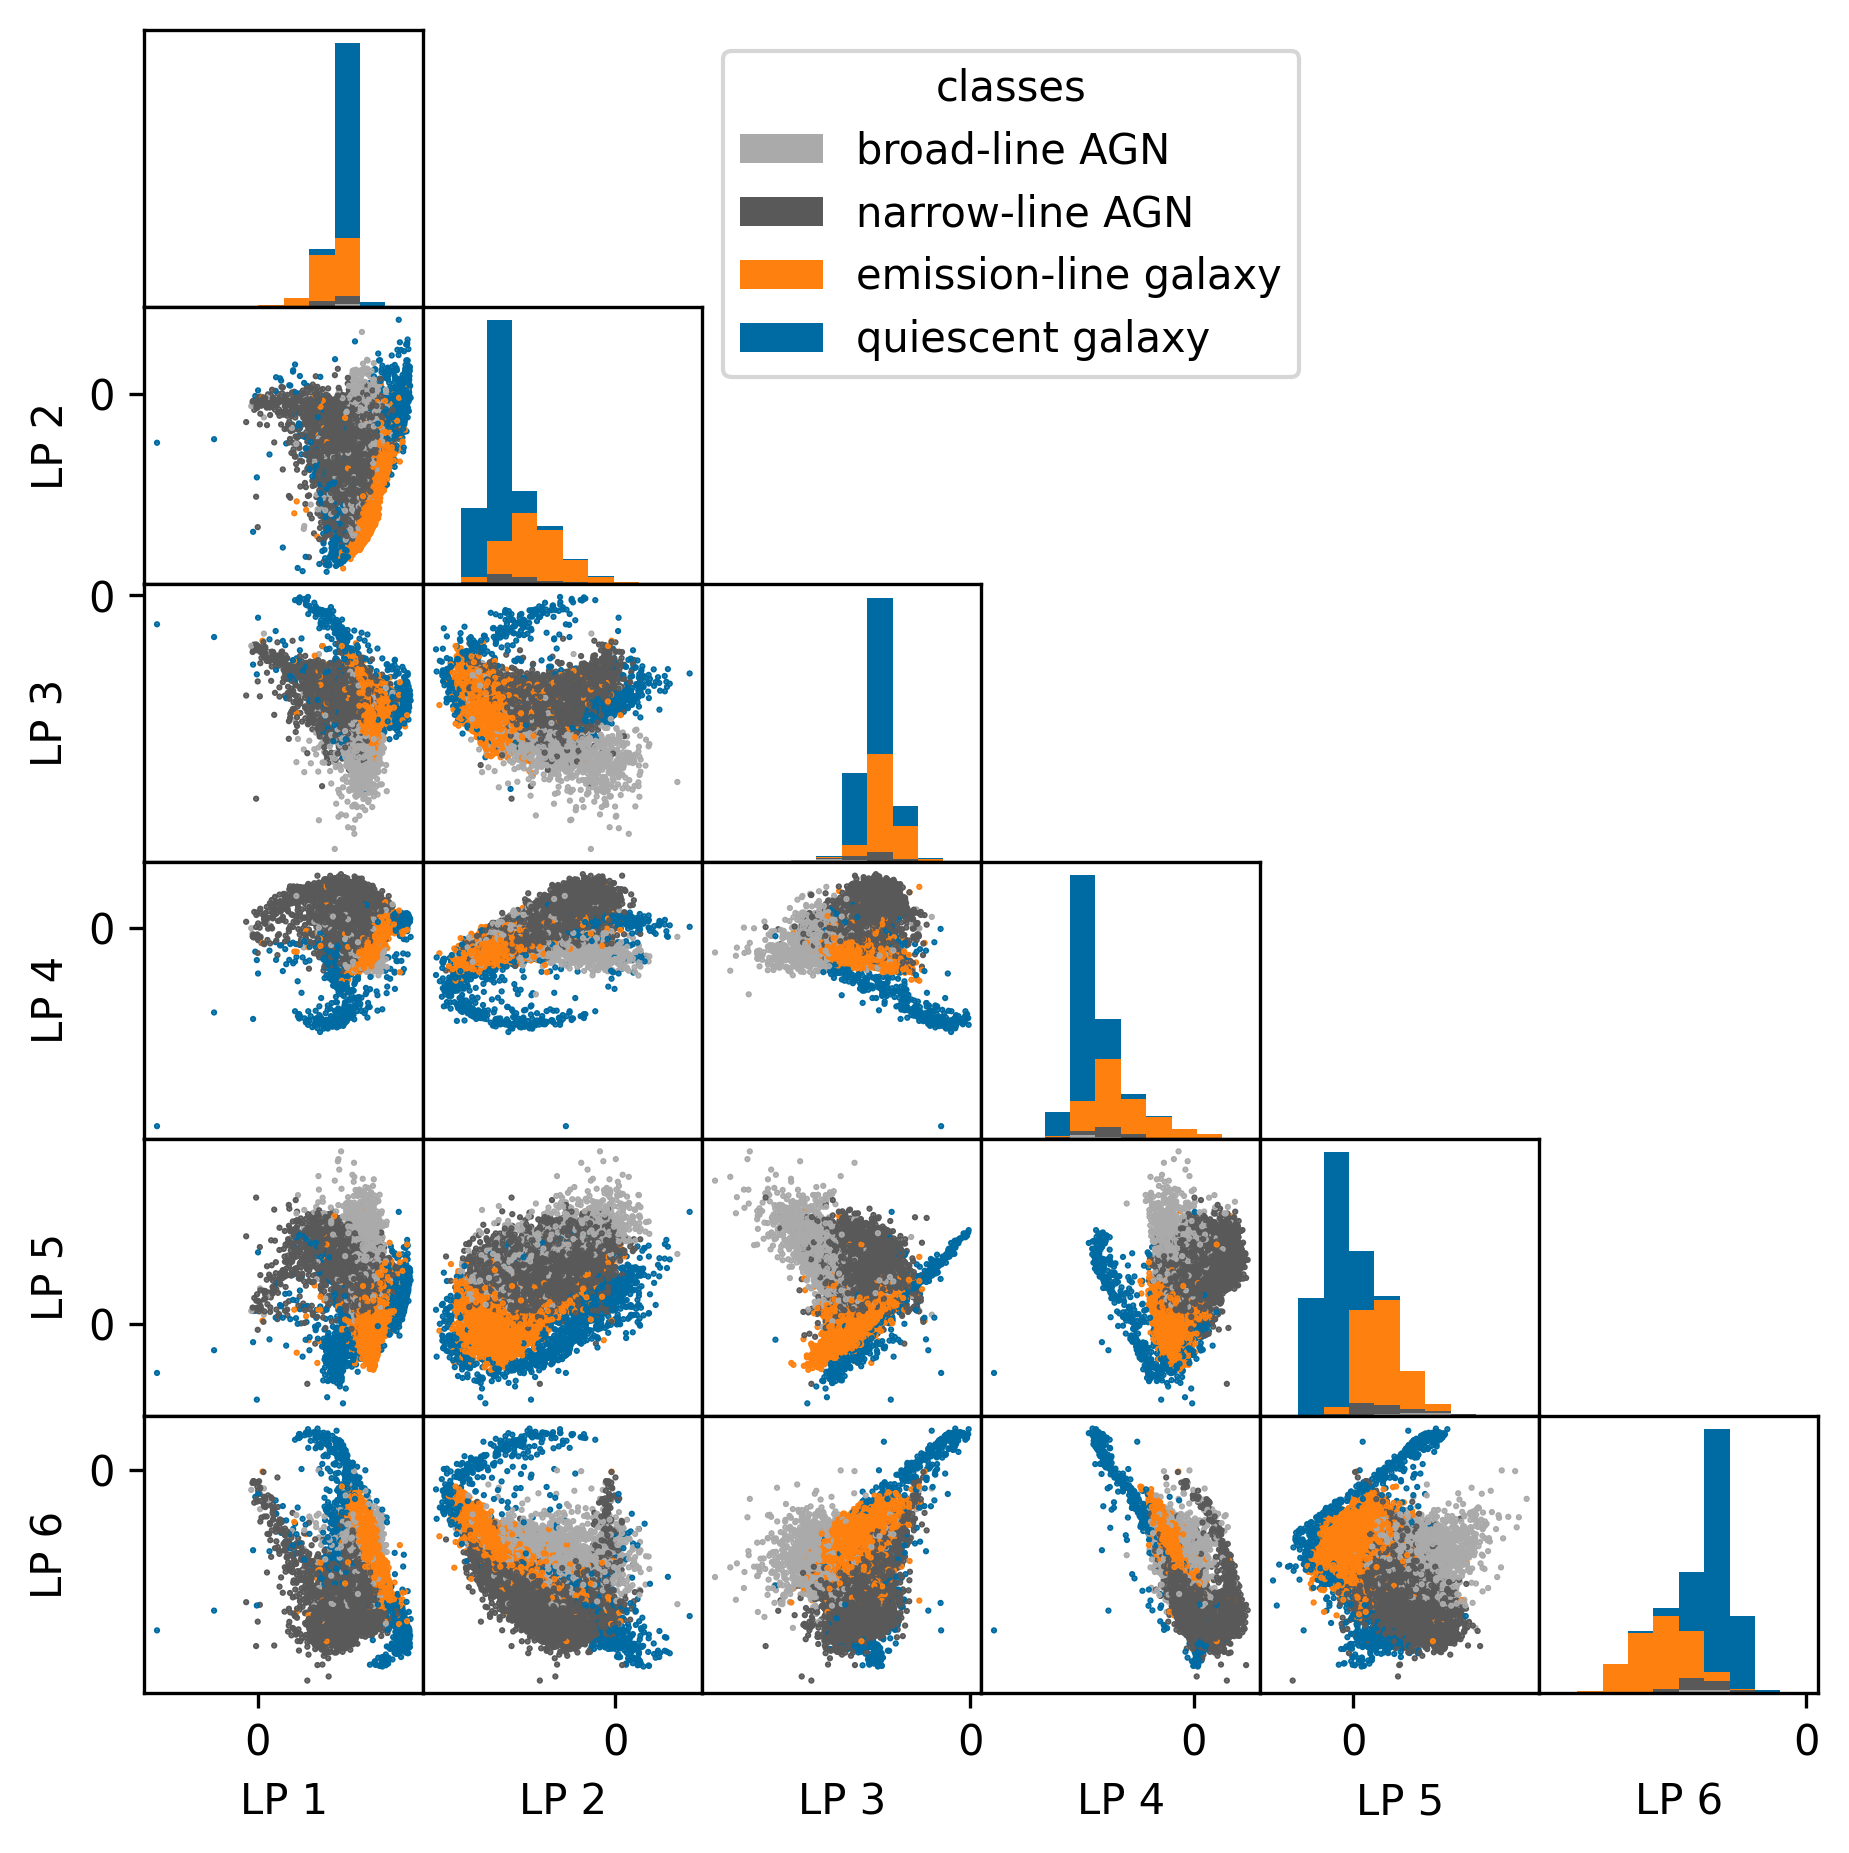

In [55]:
# Code copied directly from Portillo et al.
fig = plt.figure(figsize=(7.2,7.2), rasterized=True)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(6):
    for j in range(6):
        if i <= j:
            plt.subplot(6,6,i+j*6+1)
            if i == 0 and j != 0:
                plt.ylabel(f'LP {j + 1}')
            if j == 5:
                plt.xlabel(f'LP {i + 1}')
            if i != 0:
                plt.yticks([])
            else:
                plt.yticks([-6, -3, 0, 3, 6])
            if j != 5:
                plt.xticks([])
            else:
                plt.xticks([-6, -3, 0, 3, 6])
            if i < j:
                plt.scatter(latentmu_PCA[allidx, i],
                            latentmu_PCA[allidx, j],
                            s=1, marker='.', c=specclass[allidx],
                            cmap=cmapclass)
            if i == j:
                plt.hist([latentmu_PCA[specclass == cln, i] for cln in [3,2,1,0]],
                         stacked=True,
                         label=specclassnames[::-1],
                         color=[cmapclass(x) for x in [1., 2/3, 1/3, 0.]])
                plt.yticks([])
                if i == 0:
                    plt.legend(bbox_to_anchor=(2, 1), loc='upper left', title='classes')
plt.show()
# Save as pdf
fig.savefig('corner.pdf', bbox_inches='tight')


In [56]:
import umap
# Compressing the latent space to 2D with UMAP
umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
umap_latents = umap.fit_transform(latents)

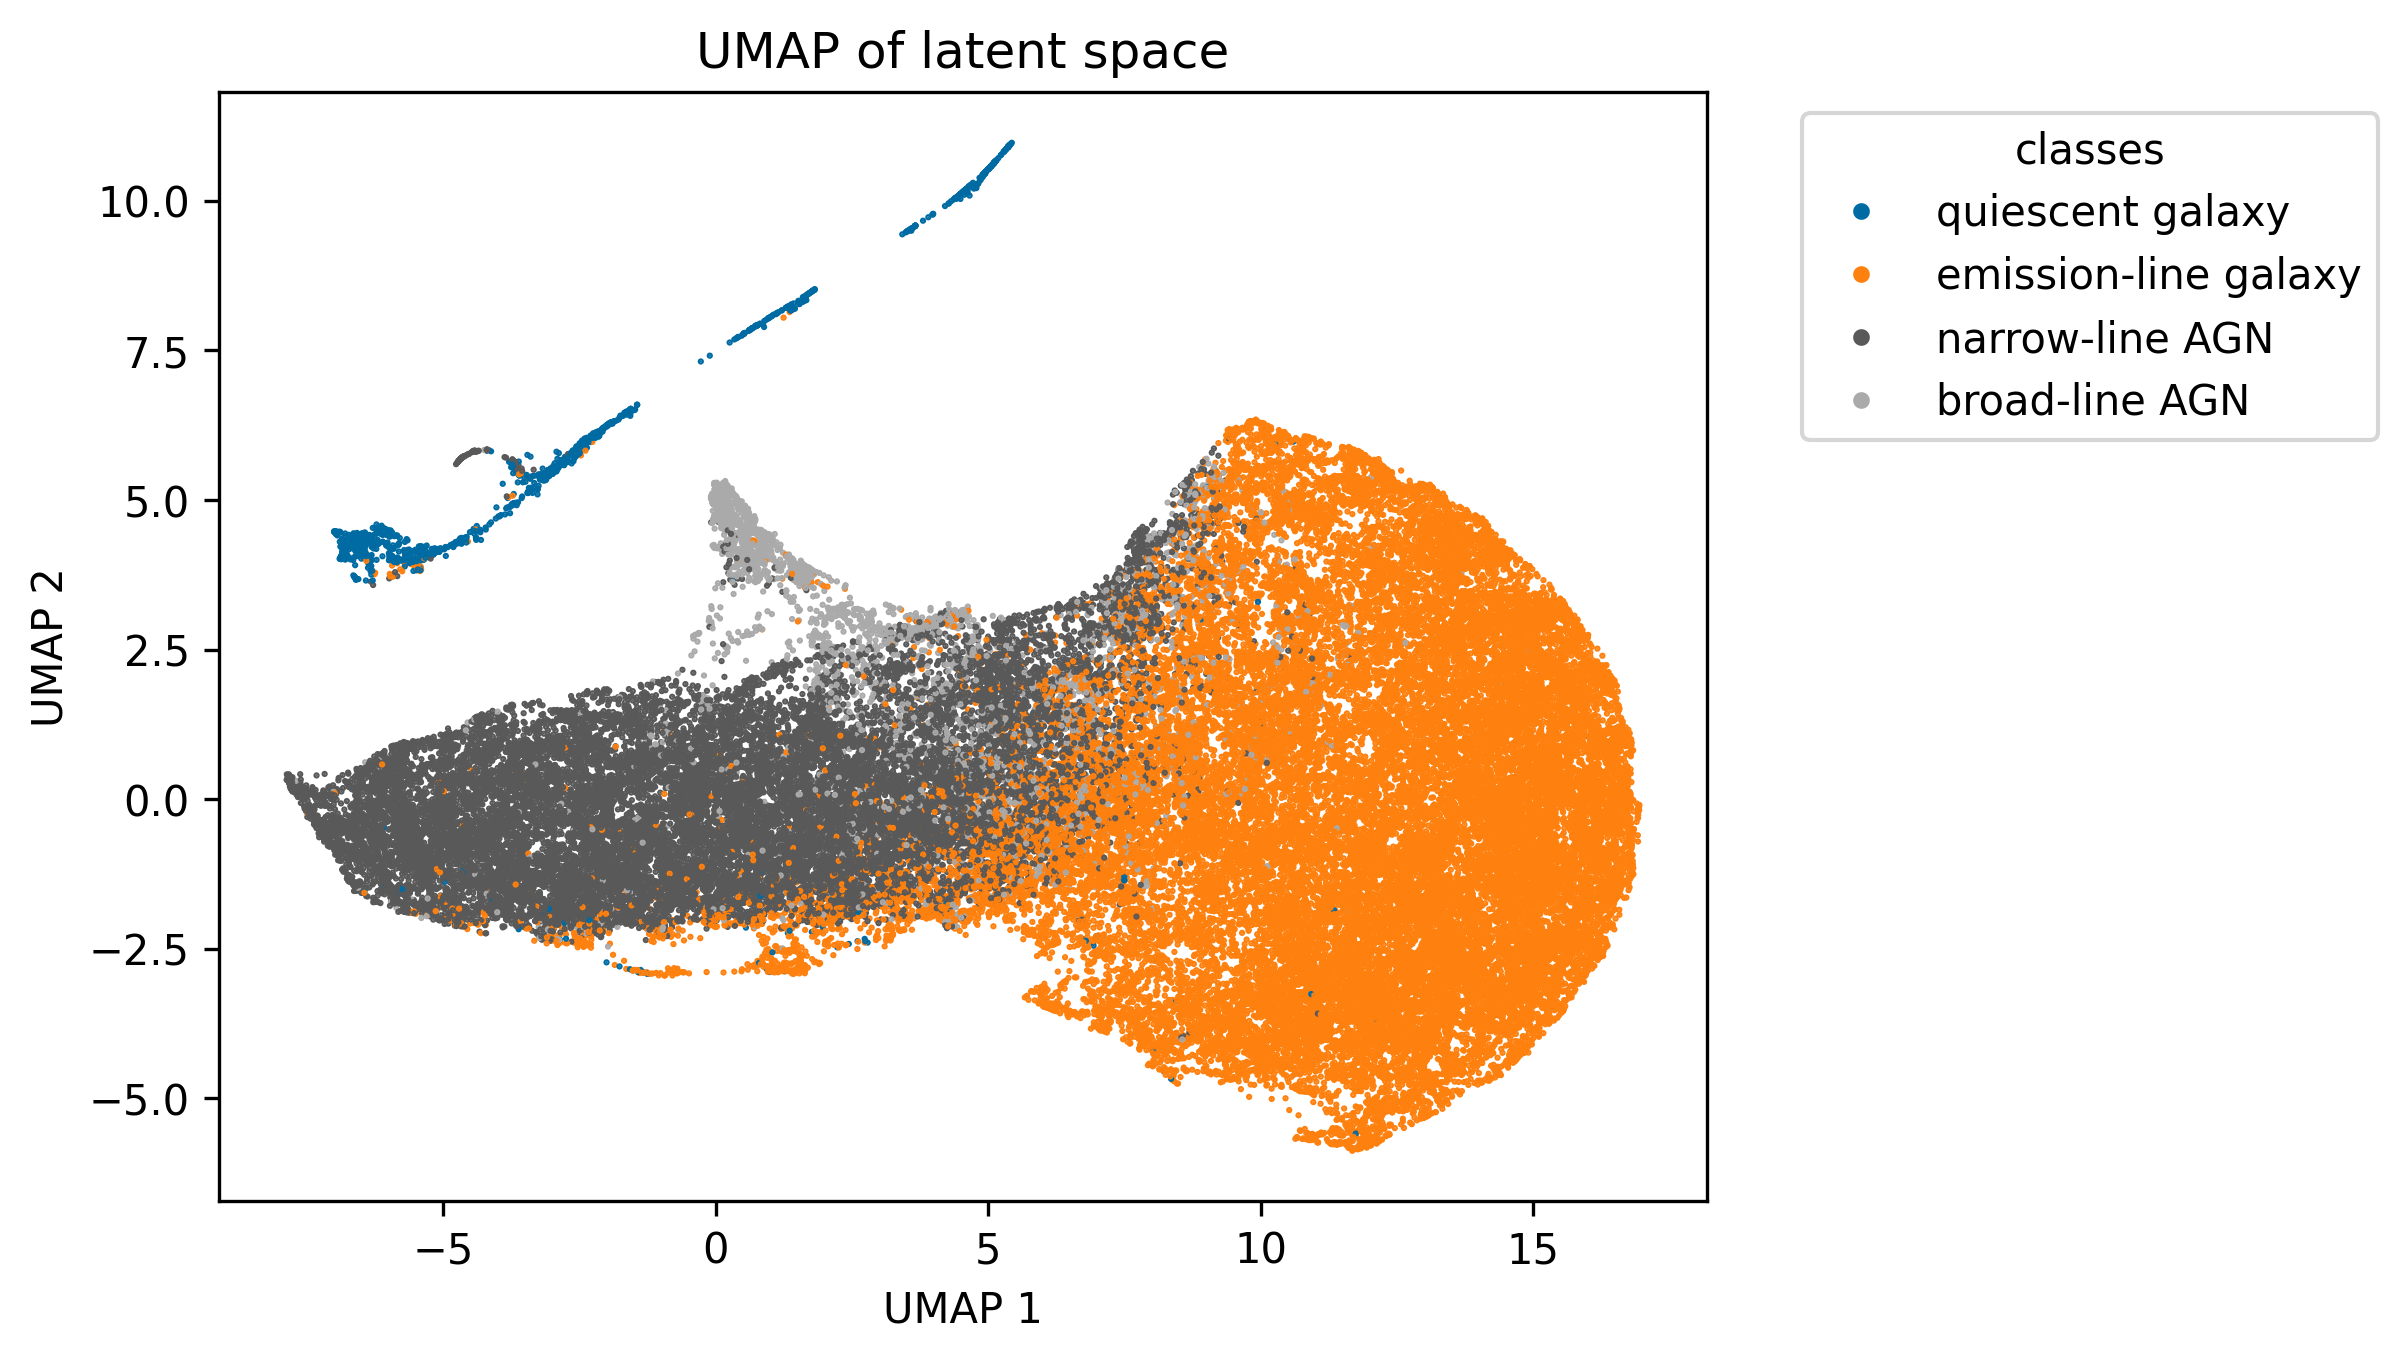

In [57]:
fig, ax = plt.subplots()

scatter = ax.scatter(umap_latents[allidx, 0], umap_latents[allidx, 1],
                     s=1, marker='.', c=specclass[allidx],
                     cmap=cmapclass, rasterized=True)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('UMAP of latent space')

# Add legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=specclassnames[cln],
               markerfacecolor=cmapclass(cln), markersize=5)
    for cln in range(4)
]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='classes')

# Save before showing
fig.savefig('umap.pdf', bbox_inches='tight')
plt.show()


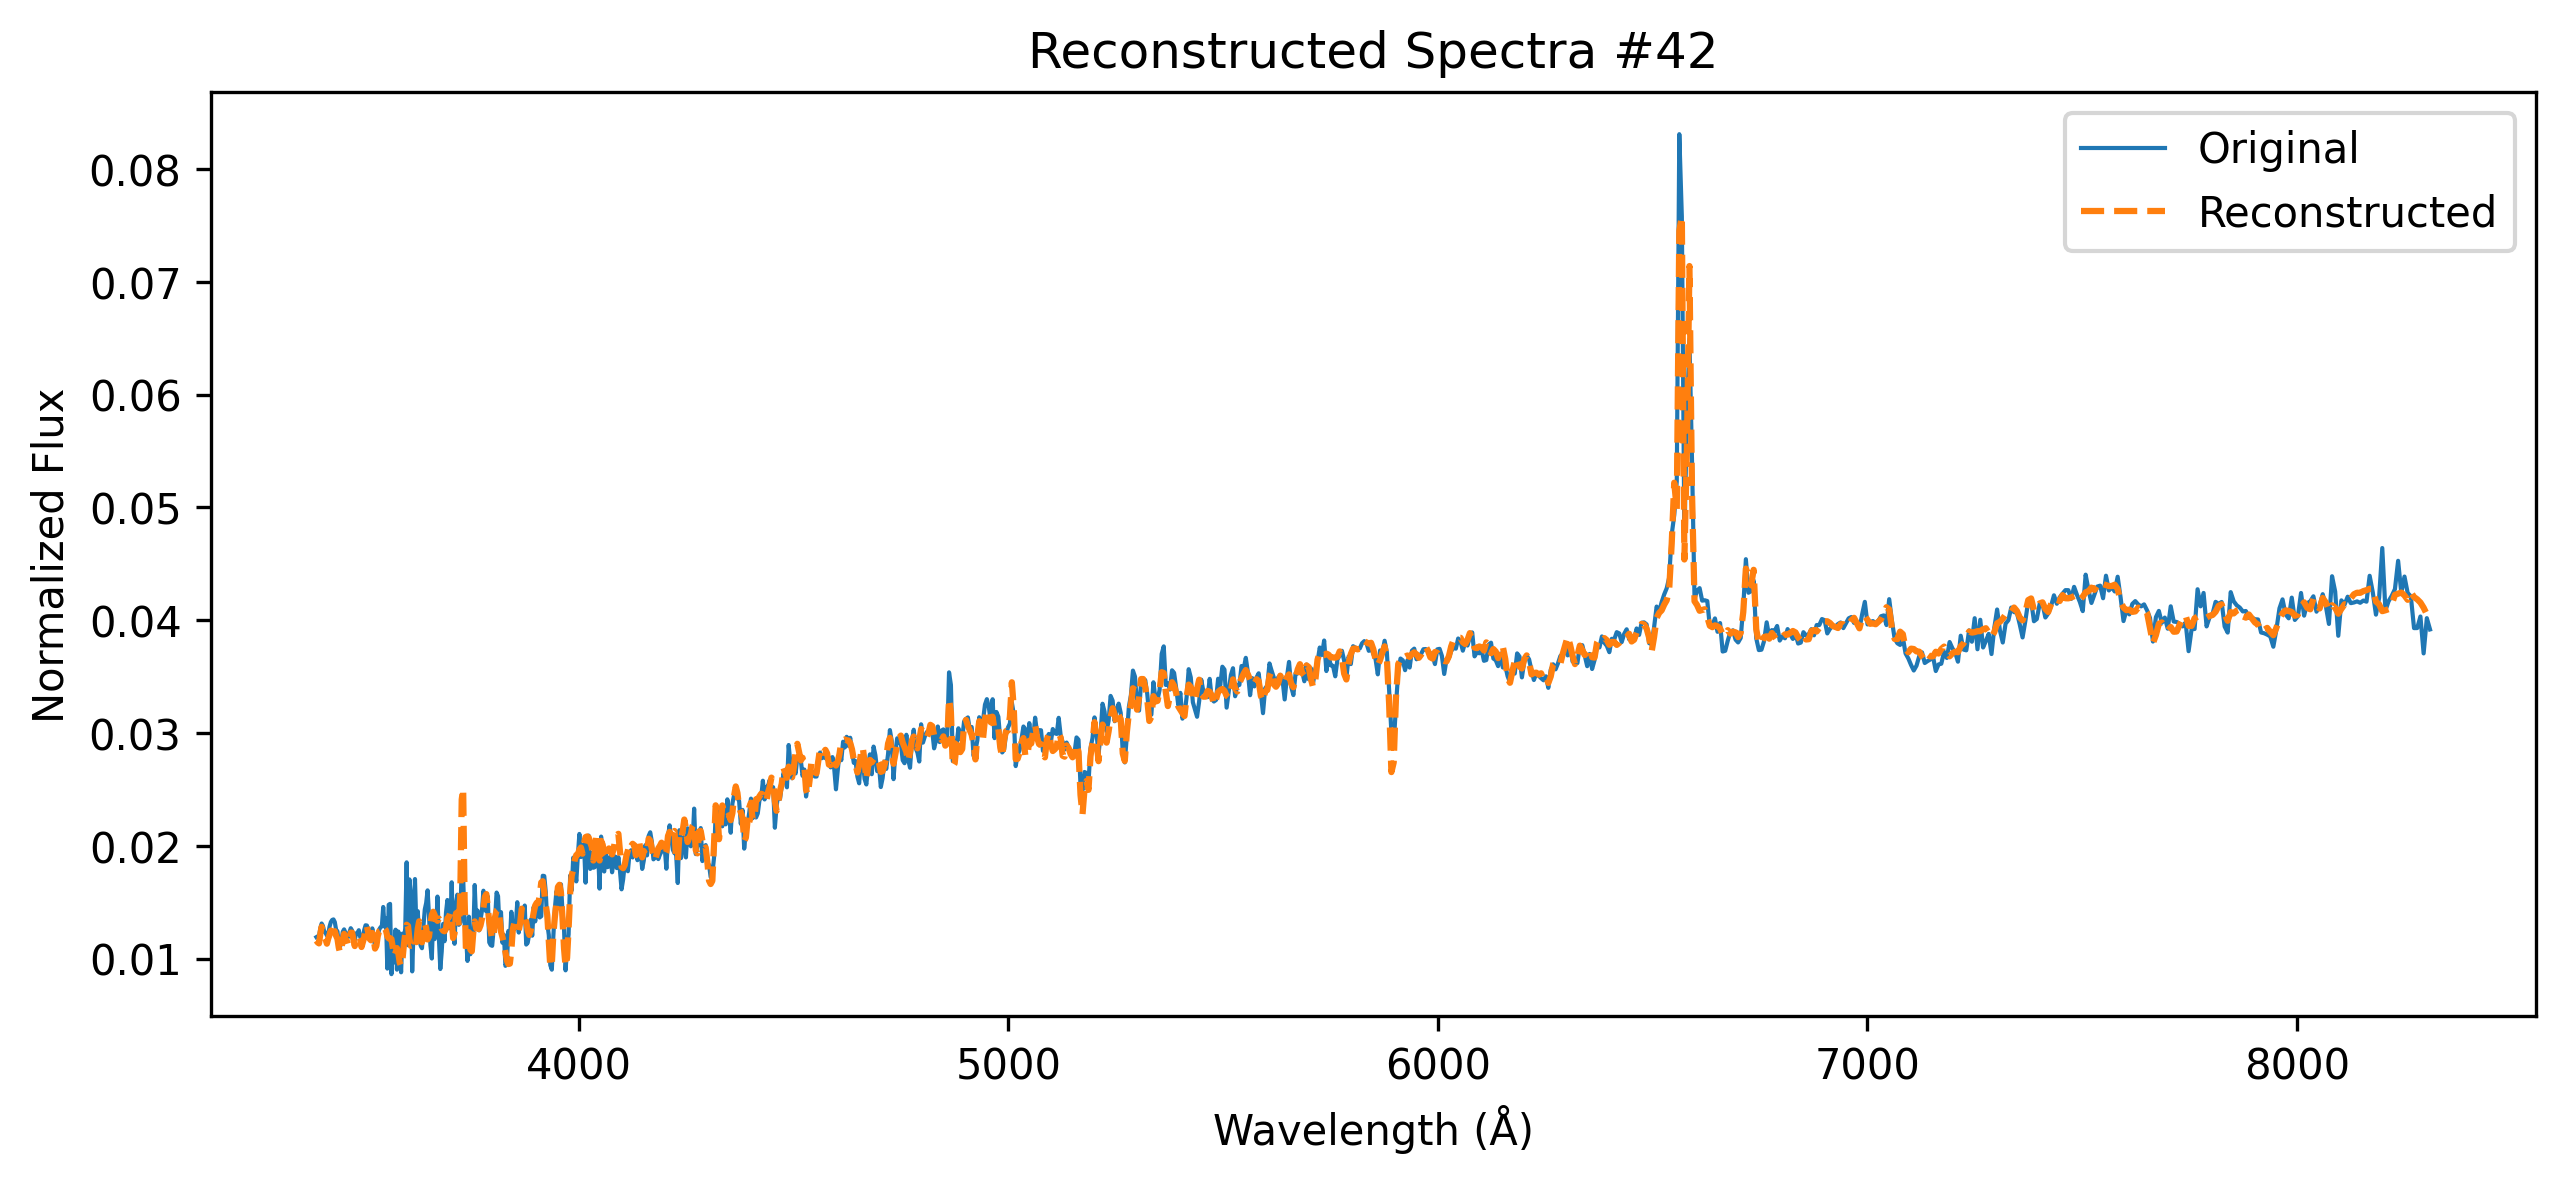

In [58]:
import matplotlib.pyplot as plt

index = 42
original = tensor_data[index].unsqueeze(0)

# Get reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(original)

# Convert to numpy for plotting
original_np = original.squeeze().numpy()
reconstructed_np = reconstructed.squeeze().numpy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(lam, original_np, label='Original', linewidth=1, rasterized=True)
ax.plot(lam, reconstructed_np, label='Reconstructed', linestyle='--', rasterized=True)
ax.legend()
ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_title(f'Reconstructed Spectra #{index}')
fig.savefig('spectrum_recon.pdf', dpi=300, bbox_inches='tight')
plt.show()  

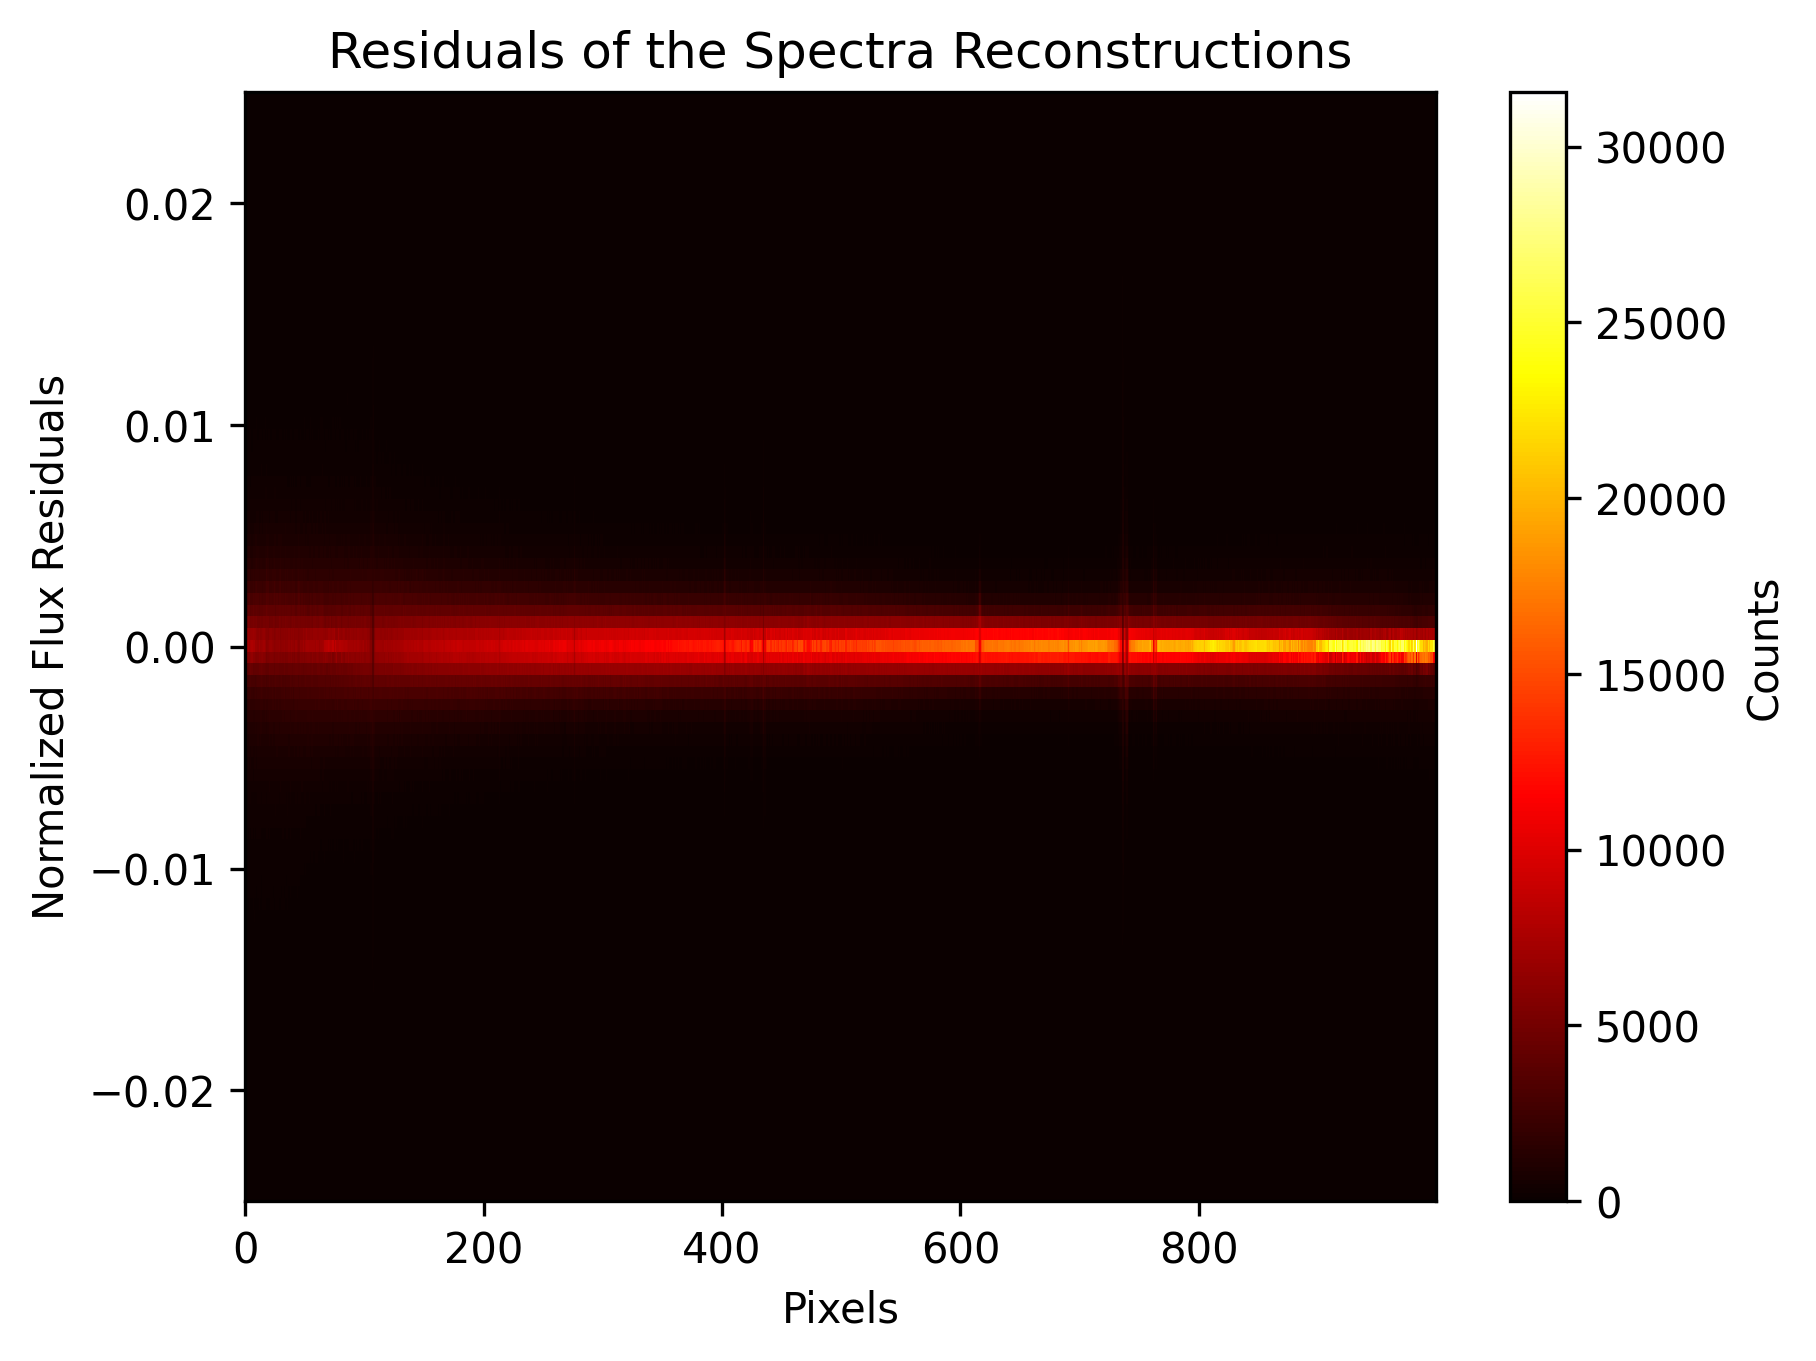

In [59]:
# Generating residuals histogram
reconstructed = model(tensor_data)
residuals = tensor_data - reconstructed
residuals = residuals.detach().numpy()
plt.hist2d(np.tile(np.arange(residuals.shape[1]), residuals.shape[0]), residuals.flatten(), bins=[1000,3000], cmap='hot', rasterized=True)
plt.ylim(-0.025,0.025)
plt.colorbar(label='Counts')
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux Residuals')
plt.title('Residuals of the Spectra Reconstructions')
plt.savefig("residuals.pdf")

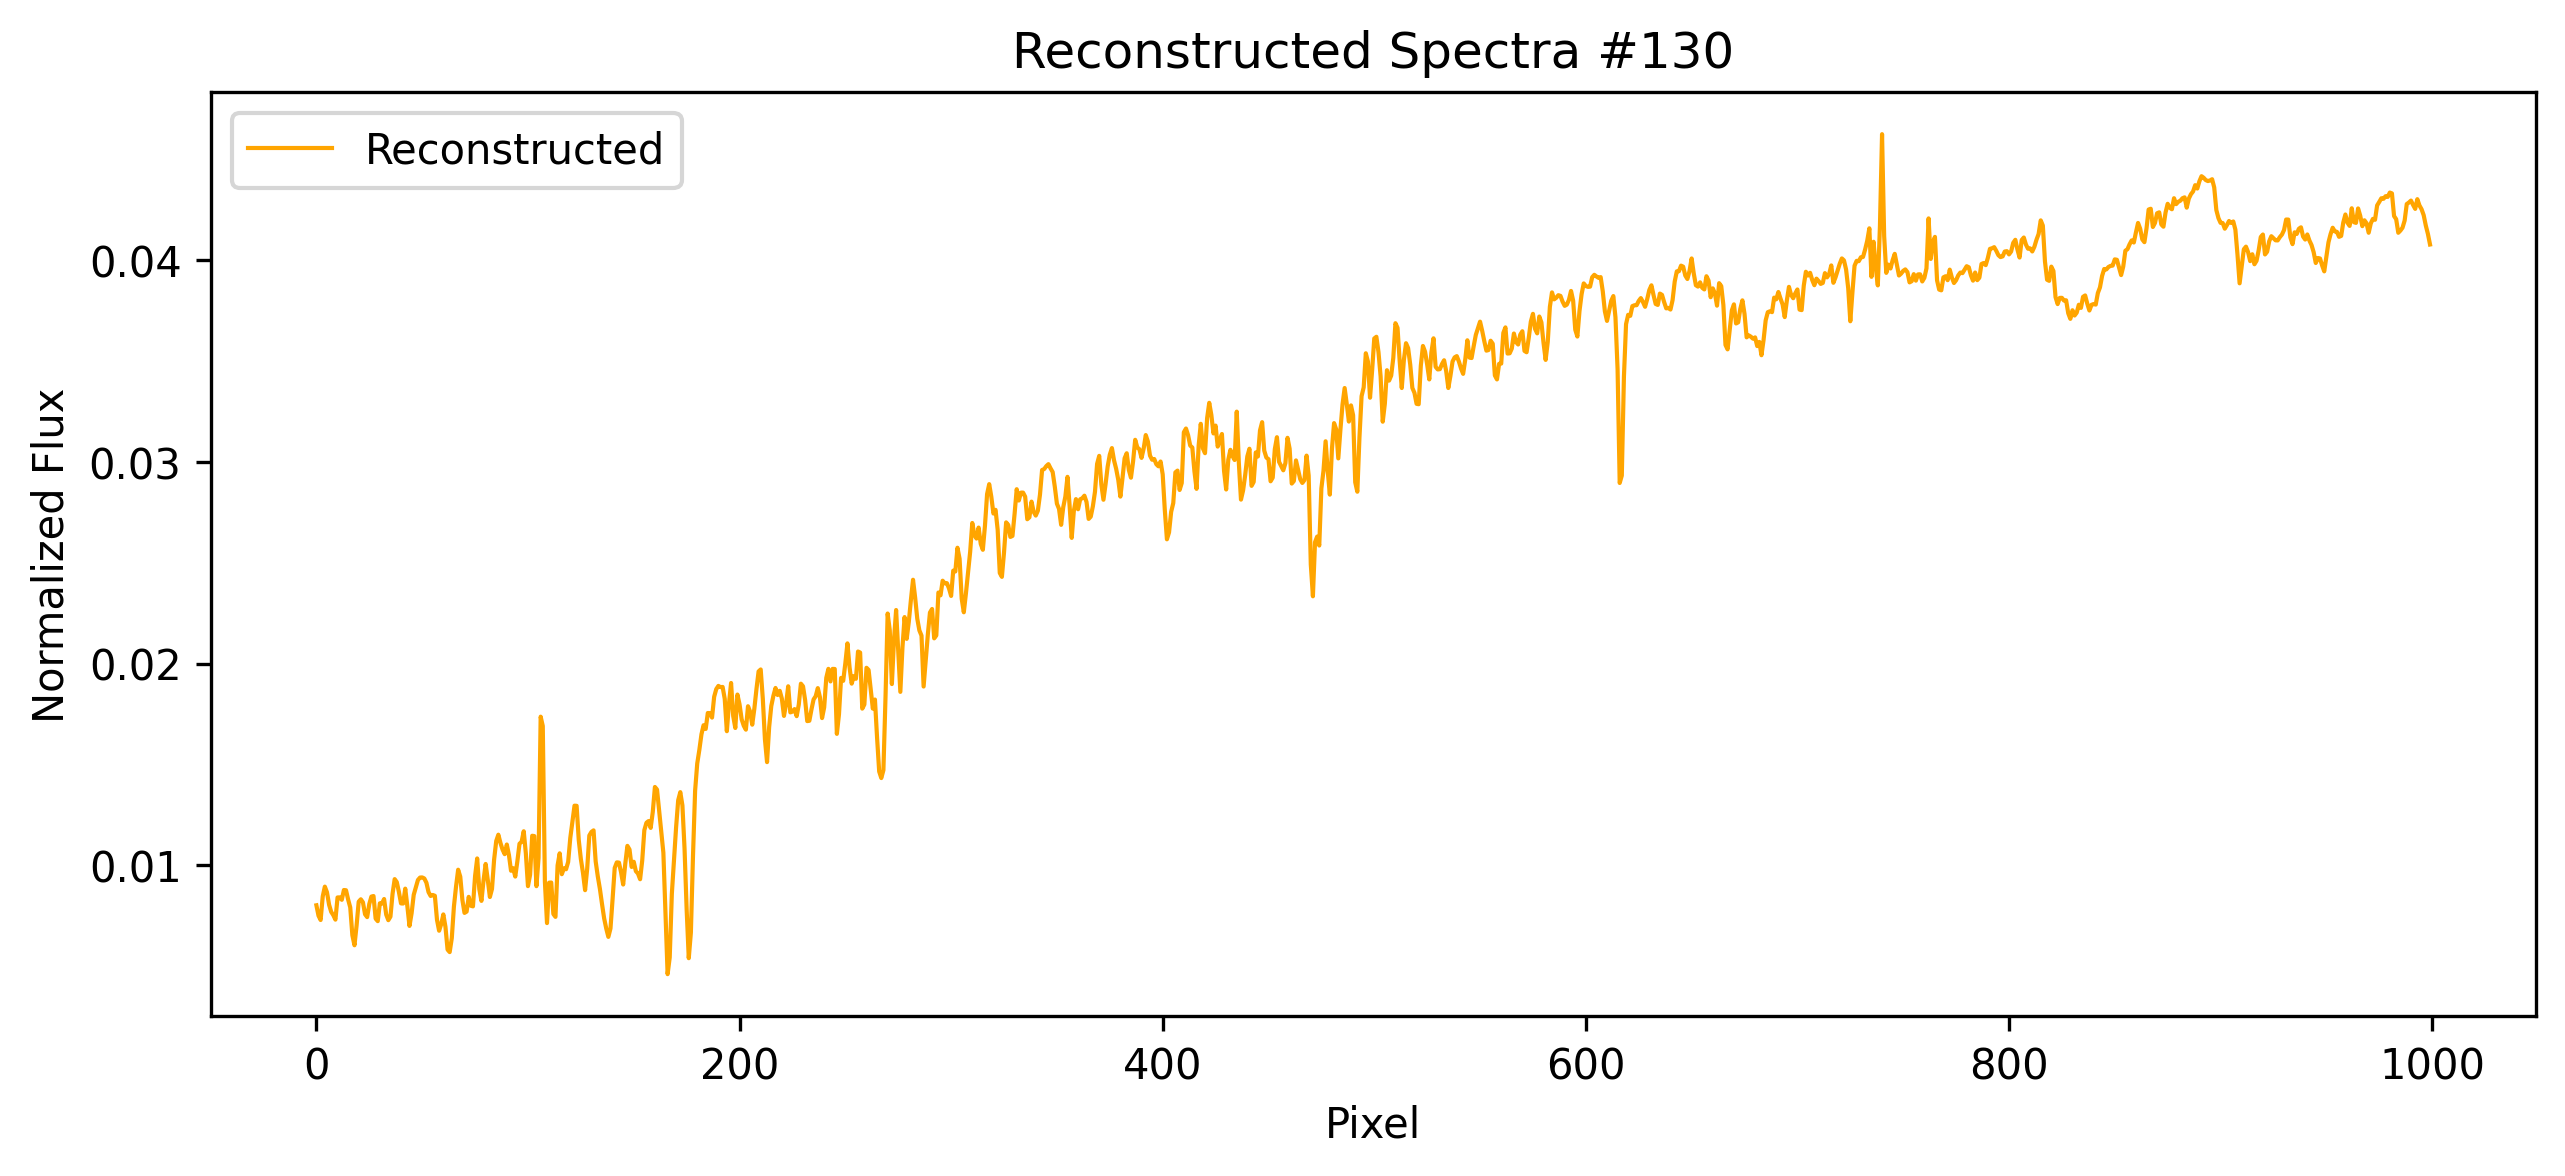

In [32]:
# This plot is used to generate the spectra used in the illustration for the autoencoder architecture
import matplotlib.pyplot as plt

index = 130
original = tensor_data[index].unsqueeze(0)  # shape: (1, 1000)

# Get reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(original)

# Convert to numpy for plotting
original_np = original.squeeze().numpy()
reconstructed_np = reconstructed.squeeze().numpy()

plt.figure(figsize=(10, 4))
# plt.plot(original_np, label='Original', linewidth=1)
plt.plot(reconstructed_np, label='Reconstructed', linewidth=1, color = 'orange')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Normalized Flux')
plt.title(f'Reconstructed Spectra #{index}')
plt.show()